Advantages of Autoencoder
- It deos not need labeled data.
- It is capable of capturing non-linear and complex relationship within data.
- It can be applied to large and high-dimensional data with ease.

Overall, autoencoder is a convenient model due to its ability to automatically calculate the correlations between features as weight values in the model.

## Environment

In [43]:
import random
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [45]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [46]:
SEED = 302
seed_everything(SEED)

## Data & Hyperparameter

In [47]:
train_df = pd.read_csv('data/train.csv') # 정상, 사기 거래의 여부를 알 수 없는(대부분 정상 거래) 신용 카드 데이터 (Unlabeled)
val_df = pd.read_csv('data/val.csv') # 정상, 사기 거래의 여부가 포함된 신용 카드 데이터 (학습 불가능)
test_df = pd.read_csv('data/test.csv') # 정상, 사기 거래의 여부를 알 수 없는(대부분 정상 거래) 신용 카드 데이터 (Unlabeled)
sample_submission = pd.read_csv('data/sample_submission.csv') # 정상:0, 사기:1

In [48]:
train_df.shape, val_df.shape, test_df.shape

((113842, 31), (28462, 32), (142503, 31))

In [49]:
train_df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,3,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,4,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,6,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,8,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,9,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901


In [50]:
val_df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,10,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0
1,22,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0
2,63,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0
3,69,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0
4,83,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0


In [51]:
class CustomDataset(Dataset):
    def __init__(self, df, eval_mode):
        self.df = df
        self.eval_mode = eval_mode
        
        if self.eval_mode:
            self.labels = self.df['Class'].values
            self.df = self.df.drop(columns=['Class']).values
        else:
            self.df = self.df.values
    
    def __getitem__(self, index):
        if self.eval_mode:
            self.x = self.df[index]
            self.y = self.labels[index]
            
            return torch.Tensor(self.x), self.y
        
        else:
            self.x = self.df[index]
            return torch.Tensor(self.x)
        
    def __len__(self):
        return len(self.df)

In [52]:
train_df = train_df.drop(columns=['ID'])
val_df = val_df.drop(columns=['ID'])
test_df = test_df.drop(columns=['ID'])

In [53]:
# Train_df의 정상/사기 여부를 알 수 없기 때문에 작은 batch_size 적용 시 batch 안의 사기 데이터가 큰 영향을 끼칠 수 있다. 
# 따라서 상대적으로 큰 batch_size를 적용한다.
batch_size = 14231 

In [54]:
train_dataset = CustomDataset(train_df, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = CustomDataset(val_df, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = CustomDataset(test_df, eval_mode=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

## Model

In [55]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(30, 64), 
            nn.BatchNorm1d(64), 
            nn.LeakyReLU(),
            nn.Linear(64, 128), 
            nn.BatchNorm1d(128), 
            nn.LeakyReLU()
        )
        self.Decoder = nn.Sequential(
            nn.Linear(128, 64), 
            nn.BatchNorm1d(64), 
            nn.LeakyReLU(), 
            nn.Linear(64, 30)
        )
        
    def forward(self, x):
        encoded = self.Encoder(x)
        decoded = self.Decoder(encoded)
        
        return decoded

저자는 feature의 개수(30)가 너무 적은 관계로 차원을 축소하는 대신 확대하여 encoding을 하고 그것을 다시 축소하여 decoding을 진행하였다고 한다.

Batch Normalization
1. Improve Training Speed: reduce the internal covariate shift (faster convergence)
2. Better Generalization: reduce the impact of small variation shift (gets better on unseen data)
3. Increase Stability: reduce the scale of inputs (prevent vanishing/exploding gradients)

## Train & Evaluation

In [56]:
class Optimization:
    def __init__(self, model, optimizer, criterion, scheduler, device, threshold):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.device = device
        self.train_loss = list()
        self.THRESHOLD = threshold
        
    def proccess_one_batch(self, x):
        self.model.train()
        decoded = self.model(x)
        loss = self.criterion(x, decoded)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def train(self, train_loader, val_loader, epochs):
        self.model.to(self.device)
        best_score = 0
        for epoch in range(epochs):
            batch_train_losses = list()
            for index, x in enumerate(train_loader):
                x = x.float().to(self.device)
                loss = self.proccess_one_batch(x)
                batch_train_losses.append(loss)
            current_training_loss = np.mean(batch_train_losses)
            self.train_loss.append(current_training_loss)
                
            with torch.no_grad():
                cos = nn.CosineSimilarity(dim=1, eps=1e-6)
                pred = list()
                true = list()
                for x, y in val_loader:
                    x = x.float().to(self.device)
                    self.model.eval()
                    decoded = self.model(x)
                    diff = cos(x, decoded).cpu().tolist()
                    batch_pred = np.where(np.array(diff)<self.THRESHOLD, 1, 0).tolist()
                    pred += batch_pred
                    true += y.tolist()
                
            score = f1_score(true, pred, average='macro')
            
            print('EPOCH [{}/{}]: Training Loss: {}, Validation Score: {}'.format(epoch, epochs, np.mean(self.train_loss), score))
            
            if self.scheduler is not None:
                self.scheduler.step(score)
            if best_score < score:
                best_score = score
                torch.save(self.model.state_dict(), 'checkpoint_AE/best_model.pth', _use_new_zipfile_serialization=False)
                print('MODEL SAVED')
        
        return self.train_loss
        
    def evaluate(self, test_loader):
        self.model.to(self.device)
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        pred = list()
        with torch.no_grad():
            for x in test_loader:
                x = x.float().to(self.device)
                self.model.eval()
                decoded = self.model(x)
                diff = cos(x, decoded).cpu().tolist()
                batch_pred = np.where(np.array(diff)<self.THRESHOLD, 1, 0).tolist()
                pred += batch_pred

        return pred

In [57]:
model = AutoEncoder()
learning_rate = 1e-2
epochs = 150
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
# ReduceLROnPlateau reduce learning rate when a metric has stopped improving for 'patience' number of epochs by a factor of 'factor'.
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)
criterion = nn.L1Loss()

In [58]:
opt = Optimization(model, optimizer, criterion, schedular, device, 0.95)
loss = opt.train(train_loader, val_loader, epochs)

EPOCH [0/150]: Training Loss: 0.5272408127784729, Validation Score: 0.0035815559202476465
MODEL SAVED
EPOCH [1/150]: Training Loss: 0.43309676833450794, Validation Score: 0.11652556387374413
MODEL SAVED
EPOCH [2/150]: Training Loss: 0.3722978246708711, Validation Score: 0.35421675092896954
MODEL SAVED
EPOCH [3/150]: Training Loss: 0.32977977115660906, Validation Score: 0.432042465843327
MODEL SAVED
EPOCH [4/150]: Training Loss: 0.2984118863940239, Validation Score: 0.4648059515807127
MODEL SAVED
EPOCH [5/150]: Training Loss: 0.27420370404918987, Validation Score: 0.47817673902059826
MODEL SAVED
EPOCH [6/150]: Training Loss: 0.2553260959684849, Validation Score: 0.4918517305240561
MODEL SAVED
EPOCH [7/150]: Training Loss: 0.23998672794550657, Validation Score: 0.4970719195452393
MODEL SAVED
EPOCH [8/150]: Training Loss: 0.22711346660637194, Validation Score: 0.5015214784552625
MODEL SAVED
EPOCH [9/150]: Training Loss: 0.21613017842173576, Validation Score: 0.5042033980974364
MODEL SAVED

Text(0, 0.5, 'MAE')

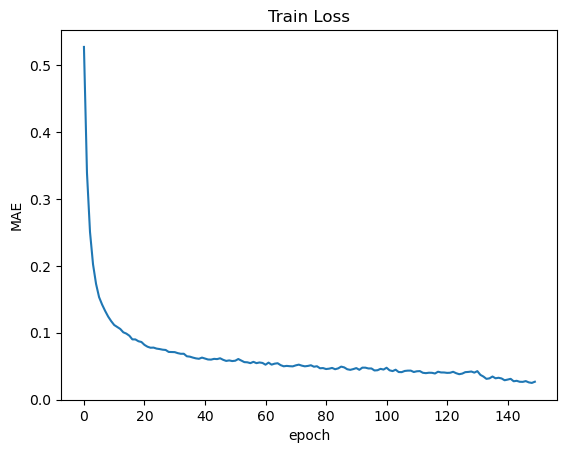

In [59]:
plt.plot(loss)
plt.title('Train Loss')
plt.xlabel('epoch')
plt.ylabel('MAE')

In [60]:
model = AutoEncoder()
learning_rate = 1e-2
epochs = 300
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)
criterion = nn.L1Loss()
model.load_state_dict(torch.load('checkpoint_AE/best_model.pth'))

<All keys matched successfully>

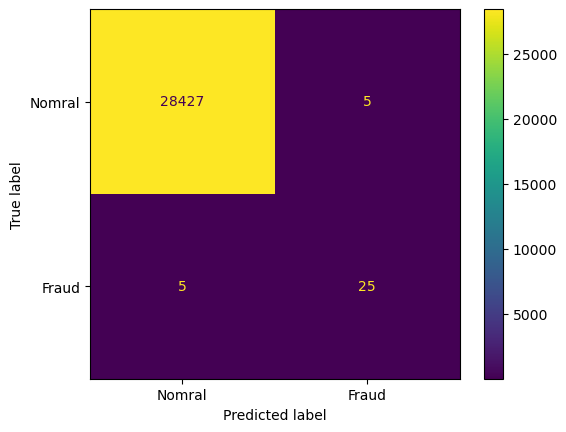

In [61]:
val_df_copy = val_df.drop('Class', axis=1)
opt = Optimization(model, optimizer, criterion, schedular, device, 0.95)
val_dataset2 = CustomDataset(val_df_copy, eval_mode=False)
val_loader2 = DataLoader(val_dataset2, batch_size, shuffle=False)
val_pred = opt.evaluate(val_loader2)
cm = confusion_matrix(val_df['Class'], val_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Nomral', 'Fraud'])
disp.plot()

In [62]:
pred = opt.evaluate(test_loader)

In [63]:
answer = sample_submission
answer['Class'] = pred
answer.to_csv('submit_autoencoder.csv', index=False)

- Public Score: 0.9140746696
- Private Score: 0.8922255835